In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import sympy
import numba
import pandas as pd
from ipywidgets import interact
import seaborn as sns
sns.set(style='ticks', context='paper', font_scale=2)
red, blue, green, purple, orange, yellow = sns.color_palette('Set1', 6)
from IPython.display import display_latex

import sys
sys.path.append('../src/')
from simulation import *
from plots import *

In [2]:
from sympy import *
init_printing()

In [3]:
from rakott.mpl import fig_xlabel, fig_ylabel, fig_panel_labels, savefig_bbox

# Recurrence illustration

In [43]:
@numba.jit()
def recurrence(x, ρ, wA, wB, N=0):
    N = int(N)
    w = x * wA + (1 - x) * wB
    x = x * (1 - ρ + ρ * wA/w)
    if N > 0:
        x = np.random.binomial(N, x) / N
    return x

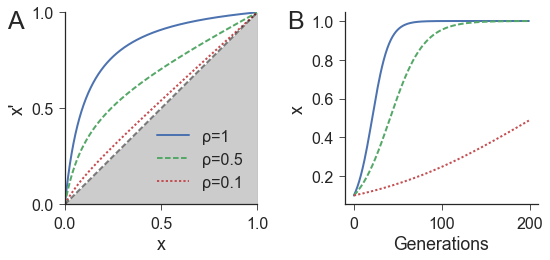

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
x = np.linspace(0, 1, 10000)
ρs = [1, 0.5, 0.1]
W = 1
w = 0.9

for ρ, ls in zip(ρs, ('solid', 'dashed', 'dotted')):
    xx = recurrence(x, ρ=ρ, wA=1.0, wB=0.1)
    ax.plot(x, xx, lw=2, ls=ls, label='ρ={}'.format(ρ))
ax.plot(x, x, ls='--', alpha=0.5, lw=2, color='k')
ax.fill_between(x, x, color='k', alpha=0.2)

ax.set(
    xlabel='x',
    ylabel='x\'',
    xlim=(0, 1),
    ylim=(0, 1),
    xticks=np.linspace(0, 1, 3),
    yticks=np.linspace(0, 1, 3),
)
ax.legend()

ax = axes[1]
n = 200
for ρ, ls in zip(ρs, ('solid', 'dashed', 'dotted')):
    x = np.empty(n)
    x[0] = 0.1
    for t in range(1, n):        
        x[t] = recurrence(x[t - 1], ρ, W, w)
    ax.plot(x, lw=2, ls=ls, label='ρ={}'.format(ρ))

# ax.legend()
ax.set_xlabel('Generations')
ax.set_ylabel('x')
fig_panel_labels(axes, xcoord=-0.3)
fig.tight_layout()
sns.despine()

fig.savefig('../figures/recurrence_example.pdf', dpi=300)
fig.savefig('../figures/recurrence_example.png', dpi=300)

In [627]:
from PIL import Image

im = Image.open('../figures/recurrence_example.png')
w, h = im.size
im.crop((0, 0, w/2, h)).save('../figures/recurrence_example_A.png')
im.crop((w/2, 0, w, h)).save('../figures/recurrence_example_B.png')

# Environment A1B1

In [44]:
@numba.jit()
def x_star(W, w, ρ):
    return 0.5 - (W + w - np.sqrt( (1 - ρ)**2 * (W - w)**2 + 4 * W * w ))/(2 * (2 - ρ) * (W - w))

In [30]:
W = 1
ws = np.logspace(-3, -0.01, 101)
ρs = np.linspace(0, 1, 101)

x = np.array([
    [
        x_star(W, w, ρ)
        for ρ in ρs
    ]
    for w in ws
])
xA1B1 = x

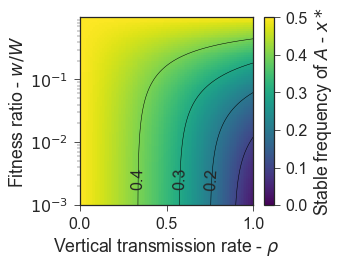

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

im = ax.pcolormesh(ρs, ws, x, cmap='viridis', vmin=0, vmax=0.5)
cntr = ax.contour(ρs, ws, x, levels=np.arange(0, 1.1, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525',use_clabeltext=True)
plt.colorbar(im, ax=ax, label='Stable frequency of $A$ - $x*$')
ax.set(
    yscale='log',
    xlabel=r'Vertical transmission rate - $\rho$',
    ylabel=('Fitness ratio - $w/W$')
)
fig.tight_layout()

fig.savefig('../figures/A1B1_stable_x.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)
fig.savefig('../figures/A1B1_stable_x.png', bbox_inches='tight')#, bbox_extra_artists=txt)

In [31]:
wbar = np.array([
    [
        x_star(W, w, ρ) * (W - w) + w
        for ρ in ρs
    ]
    for w in ws
])
wbarA1B1 = wbar

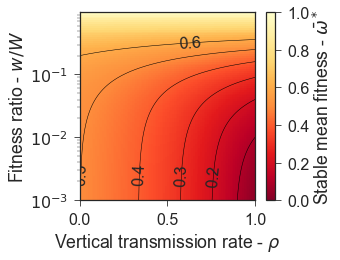

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

im = ax.pcolormesh(ρs, ws, wbar, cmap='YlOrRd_r', vmin=0, vmax=1)
cntr = ax.contour(ρs, ws, wbar, levels=np.arange(0, 0.7, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525', use_clabeltext=True)
plt.colorbar(im, ax=ax, label=r'Stable mean fitness - $\bar{\omega}^*$')
ax.set(
    yscale='log',
    xlabel=r'Vertical transmission rate - $\rho$',
    ylabel=('Fitness ratio - $w/W$')
)

fig.tight_layout()

fig.savefig('../figures/A1B1_mean_fitness.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)
fig.savefig('../figures/A1B1_mean_fitness.png', bbox_inches='tight')#, bbox_extra_artists=txt)

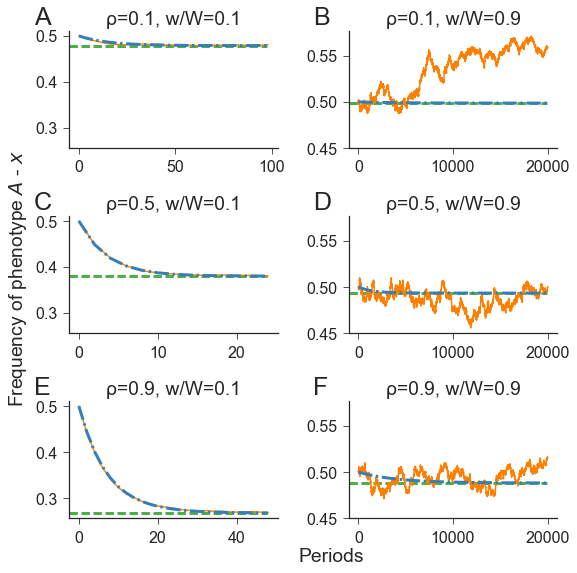

In [45]:
N = 10000
ns = np.array([[100, 20000], [25, 20000], [50, 20000]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(8, 8), sharex=False, sharey='col')

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 2)
        # analytic solution
        sol = x_star(W_, w_, ρ_)
        ax.axhline(y=sol, xmin=0, xmax=0.95, color=green, lw=3, ls='--', label='Equilibrium')        
        # WF
        reps = 100
        y_ = np.empty(n, float)
        y_[0] = 0.5
        x_ = np.empty((n, reps))
        x_[0, :] = 0.5
        for t in range(1, n):
            wA, wB = (w_, W_) if t % 2 == 0 else (W_, w_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
            x_[t, :] = recurrence(x_[t - 1, :], ρ_, wA, wB, N)
        ax.plot(t_, x_.mean(axis=1)[t_], color=orange, label='Finite population')
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-.', label='Infinite population')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.legend().set_visible(False)

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Periods', xcoord=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x$', xcoord=0.025)
fig_panel_labels(axes, ycoord=1.05)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/env_A1B1.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight');

# Environment A1B2

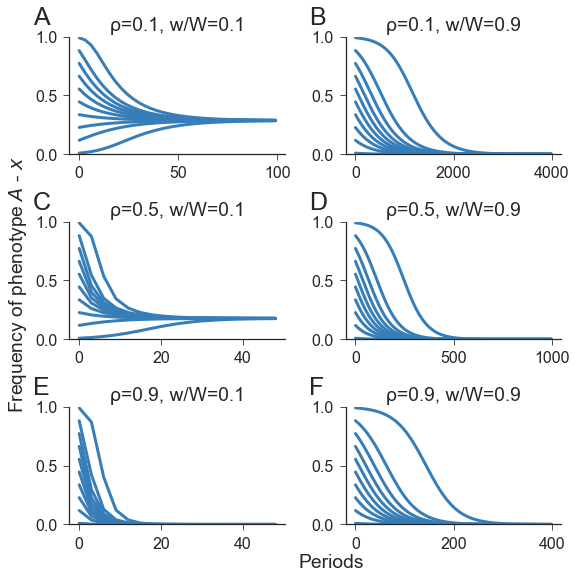

In [46]:
N = 10000
ns = np.array([[100, 4000], [50, 1000], [50, 400]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(8, 8), sharex=False, sharey="col")

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 3)
        # WF
#         reps = 100
#         x_ = np.empty((n, reps), float)
#         x_[0, :] = 0.5
        y_ = np.empty((n, 10), float)
        y_[0, :] = np.linspace(0.01, 0.99, 10)
        for t in range(1, n):
            wA, wB = (W_, w_) if t % 3 == 2 else (w_, W_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
#             x_[t, :] = recurrence(x_[t - 1, :], ρ_, wA, wB, N)
#         ax.plot(t_, x_.mean(axis=1)[t_], color=orange, label='Finite population')
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-', label='Infinite population')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.set_ylim(0, 1)
        ax.legend().set_visible(False)
#         if (x_[-1,:] == 0).all():
#             ax.text(t, 0.9, 'fixation', fontdict=dict(fontsize=14, horizontalalignment='right'))
#         else:
#             ax.text(t, 0.9, 'polymorphism', fontdict=dict(fontsize=14, horizontalalignment='right'))

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Periods', xcoord=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x$', xcoord=0.025)
labels = fig_panel_labels(axes, ycoord=1.1)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/env_A1B2.pdf', bbox_extra_artists=[xlabel, ylabel] + labels, bbox_inches='tight');

# Environment ABBABB

In [10]:
a,b,c,d,e,f,g,h = symbols('a,b,c,d,e,f,g,h'.replace(',', ' '))
x, ρ, W, w = symbols('x ρ W w')

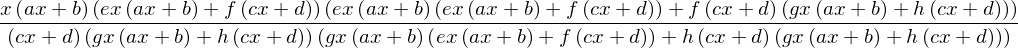

In [11]:
x1 = x*(a*x+b)/(c*x+d)
x2 = x1*(e*x1+f)/(g*x1+h)
x3 = x2*(e*x2+f)/(g*x2+h)
x3 = simplify(x3)
x3

In [12]:
x3num, x3denom = x3.as_numer_denom()
pol = (x3denom*x - x3num).subs(dict(
    e = -a,
    f = ρ*w + (1-ρ)*W,
    g = -c,
    h = W
)).subs(dict(
    a = (1-ρ)*(W-w),
    b = ρ*W + (1-ρ)*w,
    c = W-w,
    d = w,
)).as_poly(x)

In [13]:
pol.degree(), len(pol.all_coeffs())

In [14]:
pol(0), pol(1)

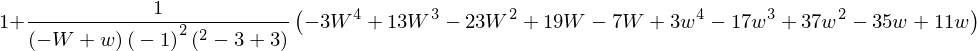

In [15]:
sympy.polys.rootoftools.RootSum(pol)

In [16]:
pol_roots = np.array(sympy.polys.rootoftools.roots(pol.subs({W:1, w:0.41, ρ:0.77}).as_poly(x), multiple=True), dtype=float)
pol_roots

array([ -2.36450967,  -1.65830915,  -0.76230214,  -0.5133686 ,
         0.        ,   1.        ,   2.60957628,  38.18343941])

In [30]:
@interact(w_=(0,1, 0.01), ρ_=(0,1, 0.01))
def _(w_, ρ_):
    pol_roots = np.array(sympy.polys.rootoftools.roots(
        pol.subs({W:1, w:w_, ρ:ρ_}).as_poly(x), multiple=True, filter='R'
    ))
    pol_roots = pol_roots[np.isreal(pol_roots)].astype(float)
    idx = (pol_roots > 0) & (pol_roots < 1) & (~np.isclose(pol_roots, 1)) & (~np.isclose(pol_roots, 0))
    print(pol_roots[idx])

In [31]:
@interact(w_=(0,1, 0.01), ρ_=(0,1, 0.01))
def _(w_, ρ_):
    plot(pol.subs({W:1, w:w_, ρ:ρ_}), (x, 0, 1))

In [17]:
roots_table = []
for w_ in np.linspace(0, 0.5, 50):
    for ρ_ in np.linspace(0, 1, 50):
        pol_roots = np.array(sympy.polys.rootoftools.roots(
            pol.subs({W:1, w:w_, ρ:ρ_}).as_poly(x), multiple=True, filter='R'
        ))
        pol_roots = pol_roots[np.isreal(pol_roots)].astype(float)
        idx = (pol_roots > 0) & (pol_roots < 1) & (~np.isclose(pol_roots, 1)) & (~np.isclose(pol_roots, 0))
        pol_roots = pol_roots[idx]
        if len(pol_roots) > 1:
            print("More than 1! w={}, ρ={}".format(w_, ρ_))
        if len(pol_roots) == 1:
            roots_table.append({'w':w_, 'ρ':ρ_, 'root':pol_roots[0]})
        else:
            roots_table.append({'w':w_, 'ρ':ρ_, 'root': np.nan})

In [18]:
roots_df = pd.DataFrame(roots_table)
roots_df.head()

,root,w,ρ
0,NaN,0.0,0.000000
1,0.326484,0.0,0.020408
2,0.319543,0.0,0.040816
3,0.312509,0.0,0.061224
4,0.305384,0.0,0.081633


In [19]:
x_pivoted = roots_df.pivot('w', 'ρ', 'root')
np.isfinite(x_pivoted.values).all()

False

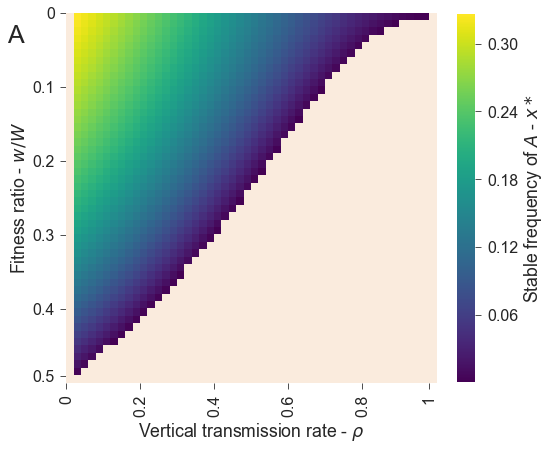

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(x_pivoted, square=True, ax=ax, cmap='viridis', 
            cbar_kws=dict(fraction=0.045, label='Stable frequency of $A$ - $x*$'))
sns.heatmap(~np.isfinite(x_pivoted), mask=np.isfinite(x_pivoted), square=True, ax=ax, cbar=False)
# cntr = ax.contourf(pivoted)
# ax.clabel(cntr, colors='w')
ax.set_xticks([0, 10, 20, 30, 40, 49])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40, 49])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'Vertical transmission rate - $\rho$')
ax.set_ylabel(r'Fitness ratio - $w/W$')
# ax.set_title(r'Polymorphism frequency in ABB - $x^*$')
fig_panel_labels(np.array(ax), 'A', xcoord=-0.16)

fig.tight_layout()
fig.savefig('../figures/A1B2_polymorphism_x.pdf')

In [21]:
def recurrence(x, ρ, wA, wB):
    return x * (1 - ρ * (1 - wA/(x * (wA - wB) + wB)))

x0 = roots_df['root']
w = roots_df['w']
x1 = recurrence(x0, roots_df['ρ'], 1, w) 
x2 = recurrence(x1, roots_df['ρ'], w, 1) 
x3 = recurrence(x2, roots_df['ρ'], w, 1) 

wbar = ((x0 * (1 - w) + w) * (x1 * (w - 1) + 1) * (x2 * (w - 1) + 1))**(1/3)

In [22]:
w_pivoted = pd.concat((roots_df, wbar), axis=1).pivot('w', 'ρ', 0)
np.isfinite(w_pivoted.values).all()

False

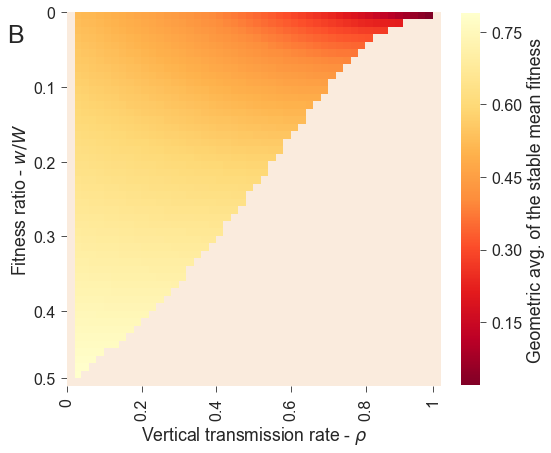

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(w_pivoted, square=True, ax=ax, cmap='YlOrRd_r', 
            cbar_kws=dict(fraction=0.045, 
                label='Geometric avg. of the stable mean fitness')#\n'+r'$(\bar{w}^* \cdot \bar{w}^{**} \cdot \bar{w}^{***})^{1/3}$')
           )
sns.heatmap(~np.isfinite(w_pivoted), mask=np.isfinite(w_pivoted), square=True, ax=ax, cbar=False)
ax.set_xticks([0, 10, 20, 30, 40, 49])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40, 49])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'Vertical transmission rate - $\rho$')
ax.set_ylabel(r'Fitness ratio - $w/W$')
# ax.set_title(r'Polymorphism frequency in ABB - $x^*$')
fig_panel_labels(np.array(ax), 'B', xcoord=-0.16)

fig.tight_layout()
fig.savefig('../figures/A1B2_polymorphism_geom_wbar.pdf')#, **savefig_bbox(cb.))

Merge with:
```sh
pdfjam figures/A1B2_polymorphism_x.pdf figures/A1B2_polymorphism_geom_wbar.pdf -o figures/A1B2_polymorphism.pdf --landscape --nup 2x1
```

# AkBl

In [24]:
@numba.jit()
def evolution(x0, W, w, ρ, N=0):
    N = int(N)
    n = len(W)
    assert n == len(w)
    x = np.zeros(n)
    x[0] = x0

    for t in range(n-1):
        W_, w_ = W[t], w[t]
        x[t+1] = x[t] * (1 - ρ * (1 - W_/(x[t] * (W_ - w_) + w_)))
        if N > 0:
            x[t+1] = np.random.binomial(N, x[t+1])/N
        t = t+1
    return x

In [25]:
@numba.jit()
def geom_avg_wbar(x, Ws, ws, k, l):
    return np.power(np.prod(
        x[-k-l:] * (Ws - ws)[-k-l:] + ws[-k-l:]
    ), 1/(k+l))

@numba.jit()
def arit_avg_wbar(x, Ws, ws, k, l):
    return np.sum(
        x[-k-l:] * (Ws - ws)[-k-l:] + ws[-k-l:]
    )/(k+l)

In [26]:
def simulate(ρ, w, k, l, n=10000):
    Ws = np.array(([1]*k + [w]*l) * (n//(k+l)), dtype=float)
    ws = np.array(([w]*k + [1]*l) * (n//(k+l)), dtype=float)
    x = evolution(0.5, Ws, ws, ρ)
    gwbar = geom_avg_wbar(x, Ws, ws, k, l)
    awbar = arit_avg_wbar(x, Ws, ws, k, l)
    return awbar, gwbar

In [27]:
w = 0.9
ρs = np.linspace(0.01, 0.99, 100, dtype=float)
ks = np.arange(1, 100, 1, dtype=int)

wbar = np.array([
    [
        simulate(ρ_, w, k_, k_)
        for ρ_ in ρs
    ]
    for k_ in ks
])
wbarAkBl = wbar

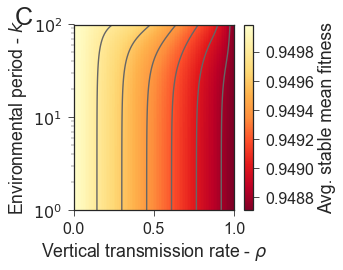

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# im = axes[0].pcolormesh(ρs, ks, wbar[:,:,0], cmap='YlOrRd_r', )
# axes[0].contour(ρs, ks, wbar[:,:,0], colors='#666666')
# axes[0].set(title='Arithmetic average')
# cb = Colorbar(im, location='lower left', length_fraction=0.5, 
#                     box_alpha=0.5, font_properties=dict(),)      
# axes[0].add_artist(cb)

im = ax.pcolormesh(ρs, ks, wbar[:,:,1], cmap='YlOrRd_r', )
ax.contour(ρs, ks, wbar[:,:,1], colors='#666666')
# ax.set(title='Geometric average')
# cb = Colorbar(im, location='lower left', length_fraction=0.5, 
#                     box_alpha=0.5, font_properties=dict(),)      
# ax.add_artist(cb)
plt.colorbar(im, label='Avg. stable mean fitness')
ax.set_xticks([0.01, 0.5, 0.99])
ax.set_xticklabels([0.0, 0.5, 1.0])
ax.set_yticks([1, 10, 100])
ax.set_xlabel(r'Vertical transmission rate - $\rho$')
ax.set_ylabel('Environmental period - $k$')
ax.set_yscale('log')

# xlabel = fig_xlabel(fig, r'Vertical transmission rate - $\rho$', ycoord=-0.05)
# xlabel.set_size(18)

fig_panel_labels(np.array(ax), 'C', xcoord=-0.37, ycoord=1)
fig.tight_layout()

fig.savefig('../figures/AkBl_stable_wbar.pdf')#, **savefig_bbox(xlabel))

# Combined

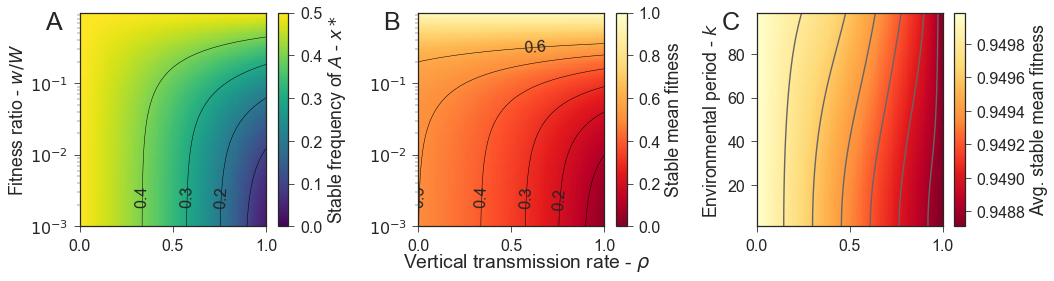

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
W = 1
ws = np.logspace(-3, -0.01, 101)
ρs = np.linspace(0, 1, 101)

im = ax.pcolormesh(ρs, ws, x, cmap='viridis', vmin=0, vmax=0.5)
cntr = ax.contour(ρs, ws, x, levels=np.arange(0, 1.1, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525',use_clabeltext=True)
plt.colorbar(im, ax=ax, label='Stable frequency of $A$ - $x*$')
ax.set(
    yscale='log',
#     xlabel=r'Vertical transmission rate - $\rho$',
    ylabel='Fitness ratio - $w/W$'
)

ax = axes[1]
im = ax.pcolormesh(ρs, ws, wbarA1B1, cmap='YlOrRd_r', vmin=0, vmax=1)
cntr = ax.contour(ρs, ws, wbarA1B1, levels=np.arange(0, 0.7, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize='smaller', fmt='%1.1f', inline=False, colors='#252525', use_clabeltext=True)
plt.colorbar(im, ax=ax, label=r'Stable mean fitness')
ax.set(
    yscale='log',
#     xlabel=r'Vertical transmission rate - $\rho$',
#     ylabel='Fitness ratio - $w/W$'
)

ax = axes[2]
W, w = 1.0, 0.9
ρs = np.linspace(0.01, 0.99, 100, dtype=float)
ks = np.arange(1, 100, 1, dtype=int)

im = ax.pcolormesh(ρs, ks, wbarAkBl[:,:,1], cmap='YlOrRd_r', )
ax.contour(ρs, ks, wbarAkBl[:,:,1], colors='#666666')

plt.colorbar(im, label='Avg. stable mean fitness')
ax.set_xticks([0.01, 0.5, 0.99])
ax.set_xticklabels([0.0, 0.5, 1.0])
# ax.set_xlabel(r'Vertical transmission rate - $\rho$')
ax.set_ylabel('Environmental period - $k$')

fig_xlabel(fig, r'Vertical transmission rate - $\rho$')
fig_panel_labels(axes, xcoord=-0.19)
fig.tight_layout()

fig.savefig('../figures/AkBl_equilibrium.pdf')#, **savefig_bbox(xlabel))